# PROJECT TO DIVIDE PLAYERS INTO 4 CLUSTERS
### Good thing: Already know the number of clusters!

* Clustering players on skills: I have put a naive method for classifying players into midfield, attack, defense and goalkeeper. I want to see if clustering can segment players into such clear-cut segments. 

### USE CASE: A young player, who does not what is his calling; I will help him...

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import data_preprocess as dp
# Import supplementary visualization code visuals.py, renamed as visuals_udacity.py. I have taken this code from the Udacity
# machine learning projects
from Utils import *

# Pretty display for notebooks
%matplotlib inline
conn = dp.uncompress_and_open_sqlite()
print ("Players")
players_df = dp.sql_to_dataframe(conn, select_all_query_table("Player_Attributes"))
display(players_df.head(n=1))
display(players_df.dtypes)

Players


id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   

      ...       vision  penalties  marking  standing_tackle  sliding_tackle  \
0     ...         54.0       48.0     65.0             69.0            69.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  

[1 rows x 42 columns]

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### Let's take all the features and see the cross-correlation between the features.

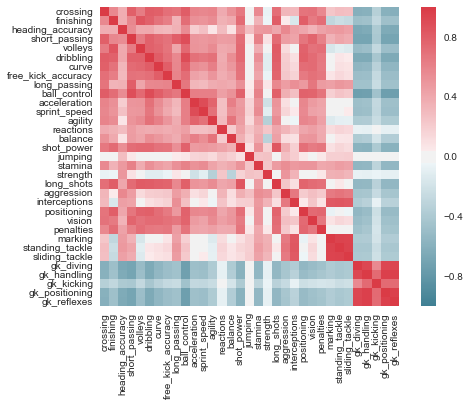

In [4]:
COLUMNS_NOT_NEEDED = ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential',
                      'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
players_skills_df = players_df.drop(COLUMNS_NOT_NEEDED, axis = 1)

import seaborn as sns

corr = players_skills_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

#### Woo! That escalated quickly..

However, notice one thing, it is very clear that all columns that belong to a goalkeeper; are very clearly not correlated with any of the other features. This makes a lot of sense; as a goalkeeper depends on reflexes, and not a lot of stamina (as he is not running as much as other players).
This also suggests that we should try segregating features as we think would be relevant to a player's type.

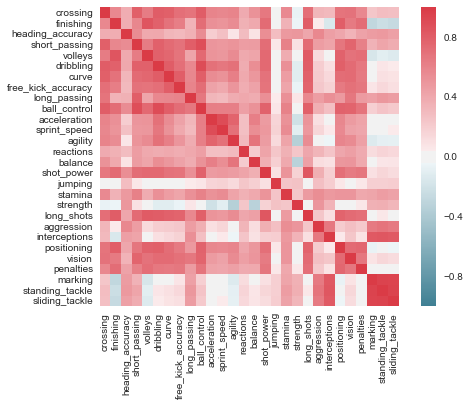

In [87]:
GK_FEATURE_COLUMNS = ['gk_diving' , 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
players_skills_df_minus_gk_features = players_skills_df.drop(GK_FEATURE_COLUMNS, axis = 1)
corr = players_skills_df_minus_gk_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

### Sampling players for validating clustering
# TODO: Create a lookup from player name to player_api_id!!

# TODO: ADD MORE PLAYERS!

In [88]:
attacker_player_row_indices = [102482, 43418, 33330]
defender_player_row_indices = [84848, 149835, 62977]
goalkeeper_player_row_indices = [142868, 72590, 83352]
midfielder_player_row_indices = [59244, 180709, 12773]


# Create a DataFrame of the chosen samples
attacker_samples = pd.DataFrame(players_skills_df.loc[attacker_player_row_indices], columns = players_skills_df.keys()).reset_index(drop = True)
print "Chosen attacker samples of the players skills dataset"
display(attacker_samples)

defender_samples = pd.DataFrame(players_skills_df.loc[defender_player_row_indices], columns = players_skills_df.keys()).reset_index(drop = True)
print "Chosen defender samples of the players skills dataset"
display(defender_samples)

goalkeeper_samples = pd.DataFrame(players_skills_df.loc[goalkeeper_player_row_indices], columns = players_skills_df.keys()).reset_index(drop = True)
print "Chosen goalkeeper samples of the players skills dataset"
display(goalkeeper_samples)

midfielder_samples = pd.DataFrame(players_skills_df.loc[midfielder_player_row_indices], columns = players_skills_df.keys()).reset_index(drop = True)
print "Chosen midfielder samples of the players skills dataset"
display(midfielder_samples)

Chosen attacker samples of the players skills dataset


crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  \
0      80.0       93.0              71.0           88.0     85.0       96.0   
1      67.0       83.0              88.0           66.0     77.0       77.0   
2      82.0       95.0              86.0           81.0     87.0       93.0   

   curve  free_kick_accuracy  long_passing  ball_control     ...       vision  \
0   89.0                90.0          79.0          96.0     ...         90.0   
1   75.0                82.0          60.0          80.0     ...         79.0   
2   88.0                77.0          72.0          91.0     ...         81.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       74.0     13.0             23.0            21.0        6.0   
1       84.0     22.0             32.0            29.0       10.0   
2       85.0     22.0             31.0            23.0        7.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         11.0        15.0            14.0          8.0  
1         11.0         8.0             6.0         14.0  
2         11.0        15.0            14.0         11.0  

[3 rows x 33 columns]

Chosen defender samples of the players skills dataset


crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  \
0      55.0       46.0              93.0           66.0     55.0       45.0   
1      45.0       39.0              77.0           70.0     51.0       58.0   
2      57.0       64.0              82.0           83.0     57.0       59.0   

   curve  free_kick_accuracy  long_passing  ball_control     ...       vision  \
0   44.0                31.0          66.0          64.0     ...         63.0   
1   51.0                27.0          69.0          64.0     ...         56.0   
2   58.0                43.0          80.0          76.0     ...         62.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       52.0     86.0             90.0            86.0       14.0   
1       54.0     74.0             79.0            77.0       12.0   
2       69.0     86.0             87.0            83.0       10.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0          5.0         6.0            15.0          8.0  
1          9.0         5.0             9.0          5.0  
2         11.0        14.0            15.0          8.0  

[3 rows x 33 columns]

Chosen goalkeeper samples of the players skills dataset


crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  \
0      19.0       12.0              19.0           35.0     17.0       12.0   
1      13.0       12.0              25.0           21.0     14.0       25.0   
2      14.0       14.0              10.0           32.0     19.0       23.0   

   curve  free_kick_accuracy  long_passing  ball_control     ...       vision  \
0   13.0                19.0          33.0          22.0     ...         17.0   
1   25.0                13.0          22.0          23.0     ...         65.0   
2   17.0                13.0          35.0          20.0     ...         42.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       23.0     11.0             13.0            12.0       83.0   
1       24.0     11.0             11.0            13.0       86.0   
2       68.0     14.0             14.0            13.0       84.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         84.0        77.0            85.0         85.0  
1         75.0        67.0            79.0         86.0  
2         81.0        75.0            84.0         88.0  

[3 rows x 33 columns]

Chosen midfielder samples of the players skills dataset


crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  \
0      79.0       72.0              65.0           82.0     79.0       74.0   
1      85.0       74.0              51.0           93.0     66.0       80.0   
2      79.0       73.0              54.0           92.0     74.0       90.0   

   curve  free_kick_accuracy  long_passing  ball_control     ...       vision  \
0   84.0                79.0          82.0          80.0     ...         77.0   
1   85.0                87.0          90.0          93.0     ...         94.0   
2   80.0                70.0          86.0          92.0     ...         92.0   

   penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0       84.0     52.0             62.0            57.0       12.0   
1       75.0     55.0             61.0            59.0        5.0   
2       71.0     57.0             57.0            56.0        6.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         14.0        15.0            10.0          8.0  
1         15.0        12.0             5.0          9.0  
2         13.0         6.0            13.0          7.0  

[3 rows x 33 columns]

In [41]:
print ("Number of samples before removing cases of no data: " + str(players_skills_df.shape[0]))
players_skills_no_na_df = players_skills_df.dropna(axis = 0, how = 'any')
print ("Number of samples after removing cases of no data: " + str(players_skills_no_na_df.shape[0]))

from sklearn.decomposition import PCA
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=2)
pca.fit(players_skills_no_na_df)
print(pca.explained_variance_ratio_)  

Number of samples before removing cases of no data: 183978
Number of samples after removing cases of no data: 181265
[ 0.46598259  0.22098651]


## Acknowledgement: This code for visualization is taken from the Udacity Customer Segments' Project

In [85]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    
    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);
    
    player_color_map = {'attacker': 'black', 'defender' : 'orange', 'goalkeeper': 'green', 'midfielder': 'white'}
    for player_type in pca_samples:
        # Plot transformed sample points 
        list_samples = pca_samples[player_type]
        ax.scatter(x = pca_samples[player_type][:,0], y = pca_samples[player_type][:,1], \
                   s = 150, linewidth = 4, color = player_color_map[player_type], marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

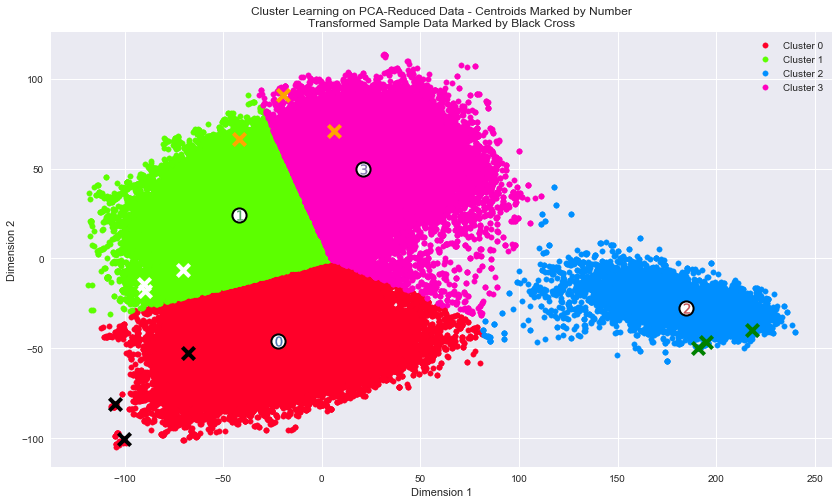

In [86]:
from sklearn.cluster import KMeans
NUMBER_OF_PLAYER_TYPES = 4
players_skills_no_na_reduced = pca.transform(players_skills_no_na_df)

# Apply pca on the samples - attack, defense, midfield etc.
pca_attacker_samples = pca.transform(attacker_samples)
pca_defender_samples = pca.transform(defender_samples)
pca_goalkeeper_samples = pca.transform(goalkeeper_samples)
pca_midfielder_samples = pca.transform(midfielder_samples)

pca_samples = dict()
pca_samples['attacker'] = pca_attacker_samples
pca_samples['defender'] = pca_defender_samples
pca_samples['goalkeeper'] = pca_goalkeeper_samples
pca_samples['midfielder'] = pca_midfielder_samples

# Create a DataFrame for the reduced data
players_skills_no_na_reduced_df = pd.DataFrame(players_skills_no_na_reduced, columns = ['Dimension 1', 'Dimension 2'])

kmeans = KMeans(n_clusters=NUMBER_OF_PLAYER_TYPES, random_state=0).fit(players_skills_no_na_reduced_df)

preds = kmeans.predict(players_skills_no_na_reduced_df)

cluster_results(reduced_data=players_skills_no_na_reduced_df, preds=preds, centers=kmeans.cluster_centers_, pca_samples= pca_samples)


In [89]:
sample_attacker_preds = kmeans.predict(pca_attacker_samples)
print sample_attacker_preds

sample_defender_preds = kmeans.predict(pca_defender_samples)
print sample_defender_preds

sample_goalkeeper_preds = kmeans.predict(pca_goalkeeper_samples)
print sample_goalkeeper_preds

sample_midfielder_preds = kmeans.predict(pca_midfielder_samples)
print sample_midfielder_preds

[0 0 0]
[3 3 1]
[2 2 2]
[1 1 1]


### Conclusion

* Notes on how the plsyers chosen are outliers, few of the best!

* How the goalkeeper cluster is so far away from everything else.

* How the mispredicted- Gerard Pique is a good finisher too! 